Final project
===
* Gruppe 3: Dominik Pegler • Elisa Grünauer • Lars Keuter
* Experiment 2: Positive instruction
* Anwendungsseminar: Experimentalpsychologische Daten analysieren mit R

## Fragestellung

Welche Validitätseffekte zeigen die Hinweisreize in der Bedingung "Positive instruction"?**

* `key_responseTarget.corr_raw` entspricht `answerCorrect`
* `key_responseTarget.rt_raw` entspricht `reactionTime`
* `key_responseTarget.keys_raw` enthält die Information, welche Taste tatsächlich von den Versuchspersonen gedrückt wurde (ist aber nicht wirklich relevant)

In [176]:
# import libraries
library(data.table)
library(tidyverse)
library(viridis)

# default settings ggplot
theme_set(theme_minimal())
update_geom_defaults("bar", list(fill = "steelblue", alpha = 0.8))
update_geom_defaults("point", list(color = "steelblue", alpha = 0.8, size = 2.6))
update_geom_defaults("boxplot", list(fill = "steelblue", alpha = 0.8))

# import data
filelist <- list.files(path = "final_data", pattern = "*.txt", full.names = TRUE)
datalist <- lapply(filelist, function(x)read.table(x, header=T)) 
df <- do.call("rbind", datalist)
setDT(df) # Convert data.frame to data.table
cat(nrow(df), "rows")

34560 rows

In [177]:
names(df)

[1] "cueType"                     "targetValidity"             
 [3] "CueDistractorPosition1"      "cueDistractor2_Position"    
 [5] "cueDistractor3_Position"     "InhibitionDistractor"       
 [7] "Target"                      "TargetColor"                
 [9] "gap_topleft"                 "gap_topright"               
[11] "gap_bottomright"             "gap_bottomleft"             
[13] "corrResp"                    "key_responseTarget.corr_raw"
[15] "key_responseTarget.rt_raw"   "sex"                        
[17] "hand"                        "key_responseTarget.keys_raw"
[19] "sbj"                         "order"                      
[21] "age"                         "instruction"

Limit to correct responses only (are stored in variable `key_responseTarget.corr_raw`)

In [178]:
df <- df[df$key_responseTarget.corr_raw == 1, ] # filter
df <- subset(df, select = -c(key_responseTarget.corr_raw)) # remove col
cat(nrow(df), "rows")

26890 rows

Limit to positive instructions only (`instruction`)

In [179]:
df <- df[df$instruction=="positive", ] # filter
df <- subset(df, select = -c(instruction)) # remove col
cat(nrow(df), "rows")

7671 rows

Remove variable `TargetColor` (is always blue)

In [180]:
df <- subset(df, select = -c(TargetColor)) # remove col

Remove redundant variable `key_responseTarget.keys_raw` (same info already in `corrResp`)

In [181]:
df <- subset(df, select = -c(key_responseTarget.keys_raw)) # remove col

Remove variables `age`, `sex` and `hand`

In [182]:
df <- subset(df, select = -c(age, sex, hand)) # remove col

Rename reaction time column to `reactionTime`, convert from factor to numeric and to milliseconds

In [183]:
df <- rename(df, reactionTime = key_responseTarget.rt_raw)
df$reactionTime <- parse_number(as.character(df$reactionTime), locale=locale(decimal_mark = ",")) * 1000 # 1000 -> seconds to milliseconds

### check variables

In [184]:
summary(df)

       cueType     targetValidity CueDistractorPosition1
 inhibition:2575   invalid:5751   topleft :5768         
 match     :2532   valid  :1920   topright:1903         
 non-match :2564                                        
                                                        
                                                        
                                                        
 cueDistractor2_Position cueDistractor3_Position  InhibitionDistractor
 bottomleft :1917        bottomleft:5749         bottomleft :1910     
 bottomright:5754        topright  :1922         bottomright:1921     
                                                 topleft    :1929     
                                                 topright   :1911     
                                                                      
                                                                      
         Target     gap_topleft  gap_topright gap_bottomright gap_bottomleft
 bottomleft :1920   down :2

### data cleaning

* eliminate person with the least correct responses?
* eliminate rows with reaction time greater 1 second or smaller than 0.15 seconds.

In [185]:
aggregate(df$sbj, list(df$sbj), FUN=length)

Group.1,x
1,388
2,370
3,341
4,394
5,409
6,406
7,398
8,392
9,408
10,405


Sbj 3 has the least corr responses (341), but is not really an outlier, I would therefor keep the subject.

Limit to response times

In [186]:
df <- df[df$reactionTime<=1000 & df$reactionTime >= 150,]
cat(nrow(df), "rows")

7671 rows

## Validity effects

In [187]:
df_valid <- df[df$targetValidity=="valid", ]
df_valid <- subset(df_valid, select = -c(targetValidity)) # remove col

df_invalid <- df[df$targetValidity=="invalid", ]
df_invalid <- subset(df_invalid, select = -c(targetValidity)) # remove col

In [188]:
nrow(df_valid)

[1] 1920

In [189]:
mean(df_valid$reactionTime)

[1] 543.5758

In [190]:
sd(df_valid$reactionTime)

[1] 113.2674

In [191]:
nrow(df_invalid)

[1] 5751

In [192]:
mean(df_invalid$reactionTime)

[1] 559.1591

In [193]:
sd(df_invalid$reactionTime)

[1] 104.0098

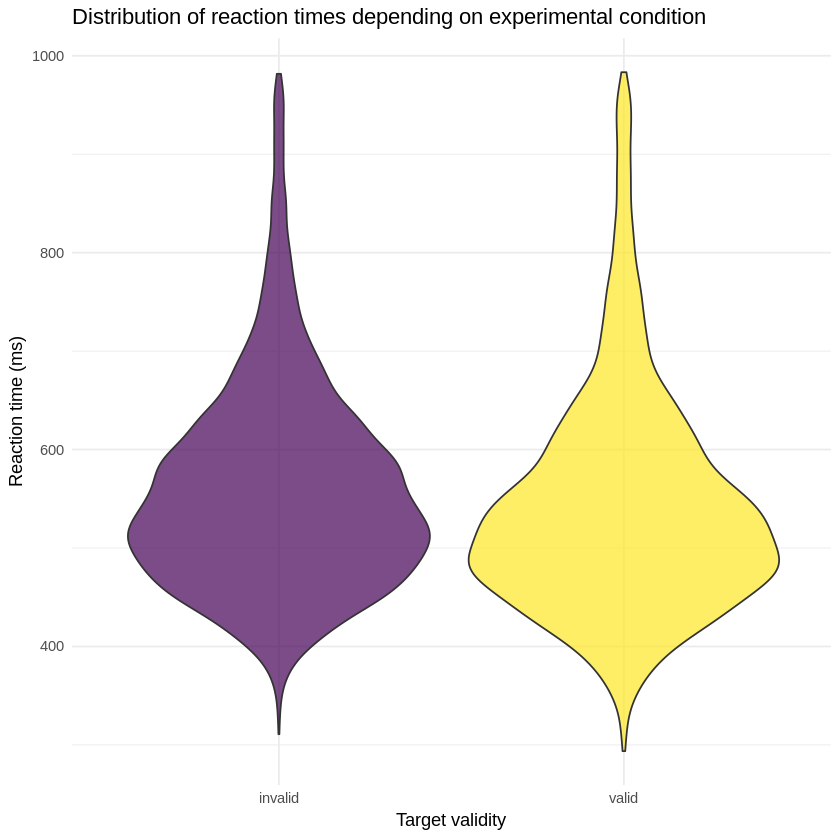

In [194]:
ggplot(df, aes(x=targetValidity, y=reactionTime)) + 
geom_violin(aes(fill=targetValidity), alpha=0.7) +
scale_fill_viridis(discrete=TRUE) +
xlab("Target validity") +
ylab("Reaction time (ms)") + 
labs(title="Distribution of reaction times depending on experimental condition") +
guides(fill = "none")